In [1]:
import numpy as np
from scipy.stats import spearmanr
from scipy.signal import hilbert
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm



sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from fc_utils import read_data, read_metrics_filepath
from graph_utils import data2percentile

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

222 13734


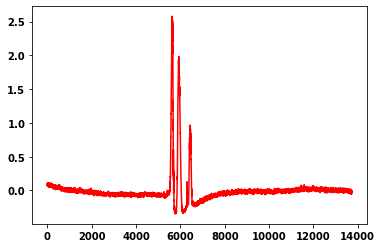

In [66]:
fish_id = 1
traces_filepath = '../data/mouse-sz-%i.npz' % fish_id
bin_filepath    = '/mnt/f/dhh-soltesz-lab/mouse-fc/sz%i/bin' % fish_id
gt_filepath     = '/mnt/f/dhh-soltesz-lab/mouse-fc/sz%i/gt' % fish_id
snap_filepath   = '/mnt/f/dhh-soltesz-lab/mouse-fc/sz%i/snap' % fish_id
metrics_filepath = '/mnt/f/dhh-soltesz-lab/mouse-fc/sz-%i/graph-metrics' % fish_id

nmatrices = 1702
window = 120
hop    = 8

f = np.load(traces_filepath)
traces = f['traces'].T
f.close()
N, T = traces.shape
#complete_times = np.arange(0, traces.shape[1]) * 0.5
#dynamic_times  = complete_times[window:]
print(N,T)

plt.figure()
plt.plot(np.mean(traces,axis=0), color='r')

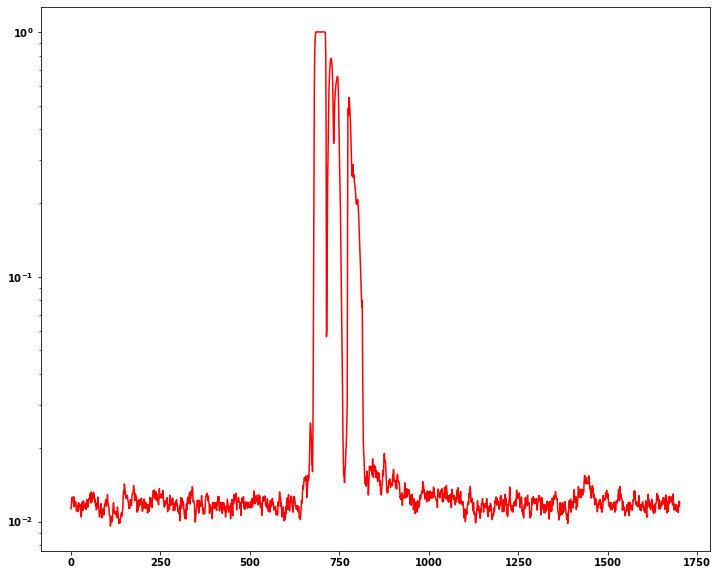

In [68]:
## Plot dynamic edge density

f = np.load('%s/densities.npz' % metrics_filepath)
densities = f['densities']
f.close()

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(densities, color='r')
ax.set_yscale('log')


<Figure size 864x576 with 0 Axes>

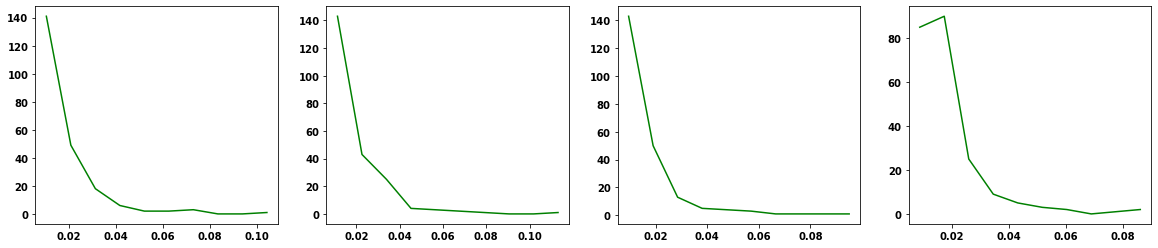

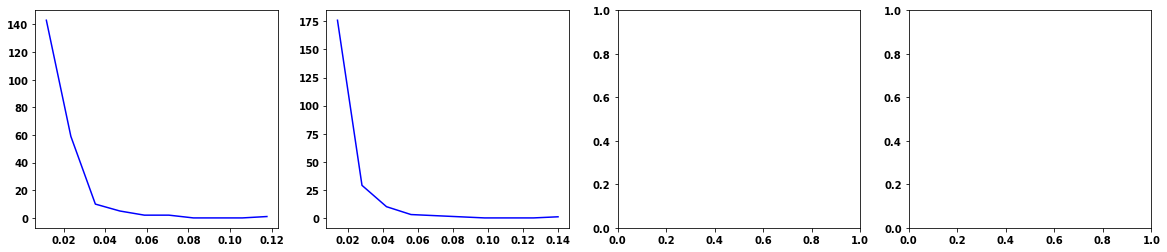

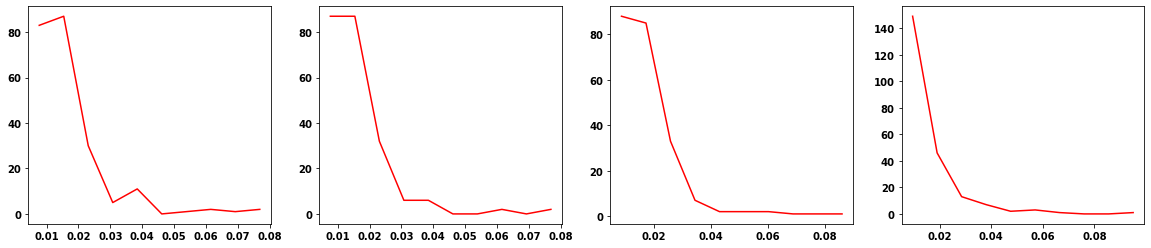

In [75]:
color=cm.cool(np.linspace(0,1,nmatrices))
bins = np.linspace(0.0, np.max(dynamic_degree_centrality), 50)
plt.figure(figsize=(12,8))


# baseline
fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(10,14), color[10:14])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='g', alpha=1.0)
plt.show()

fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(1700,1704), color[1700:1704])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='b', alpha=1.0)
plt.show()


start = sz_start_idx + 10
stop = start + 4
fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(start,stop), color[start:stop])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='r', alpha=1.0)
plt.show()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


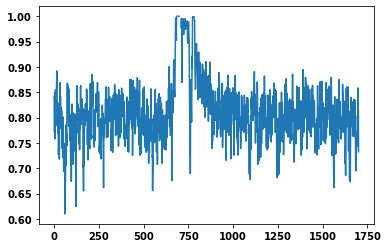

In [83]:
dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, verbose=True)
dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
method = 'max'

for i in range(len(dynamic_degree_centrality)):
    dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
    dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
    dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

dynamic_ev_deg_correlation = []
for i in range(len(dynamic_degree_centrality_percentile)):
    deg = dynamic_degree_centrality_percentile[i]
    ev  = dynamic_eigenvector_centrality_percentile[i]
    
    rho, _ = spearmanr(deg, ev)
    dynamic_ev_deg_correlation.append(rho)
    
plt.figure()
plt.plot(dynamic_ev_deg_correlation)


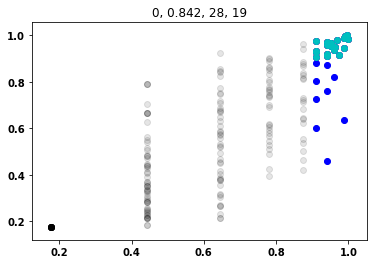

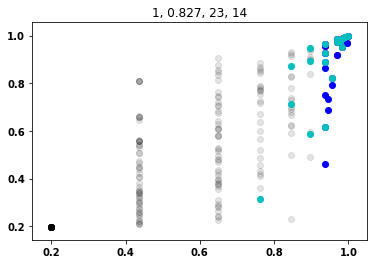

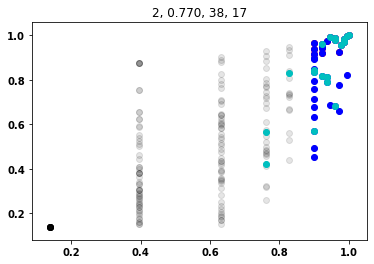

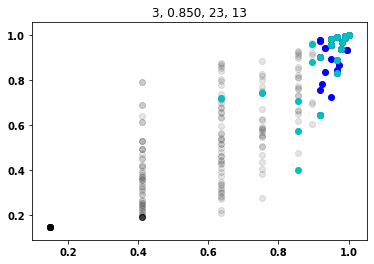

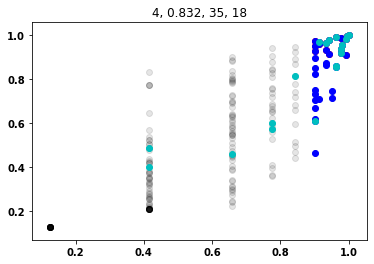

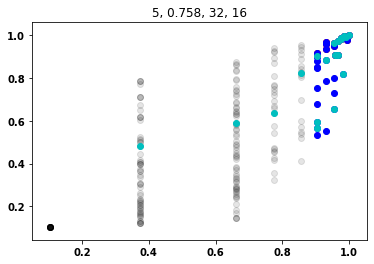

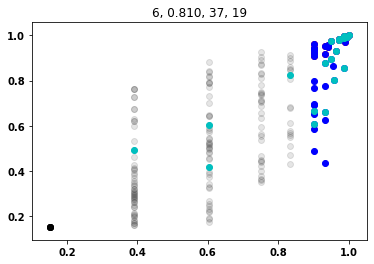

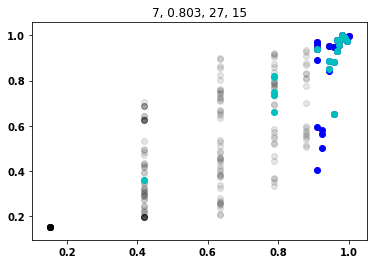

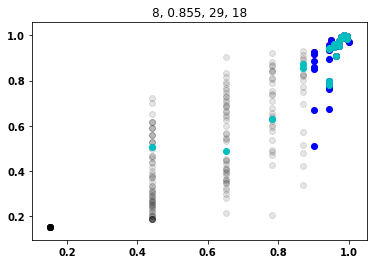

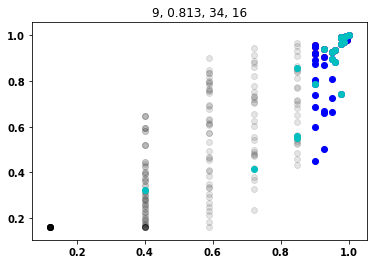

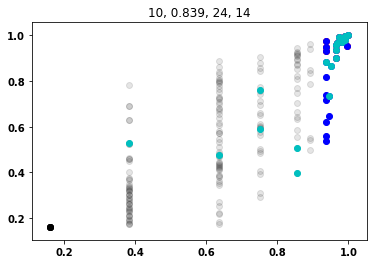

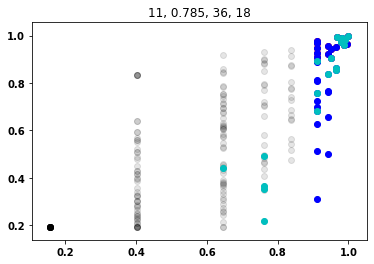

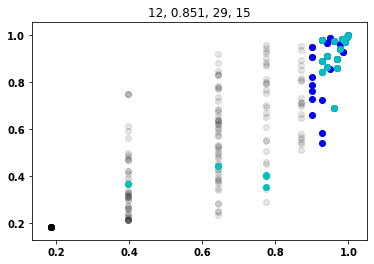

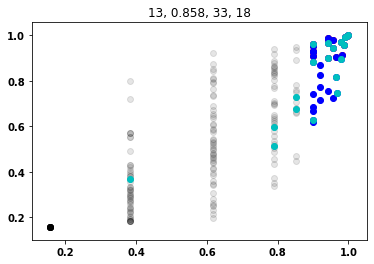

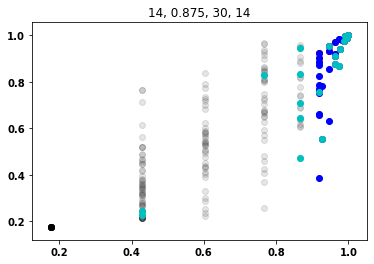

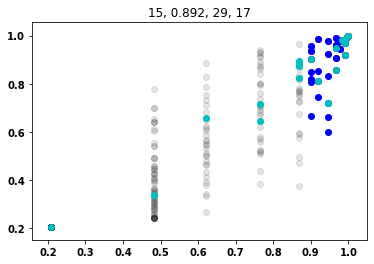

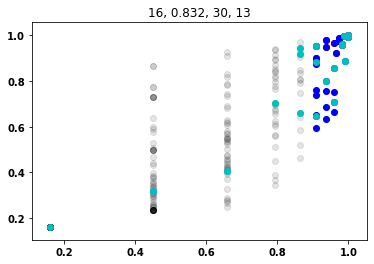

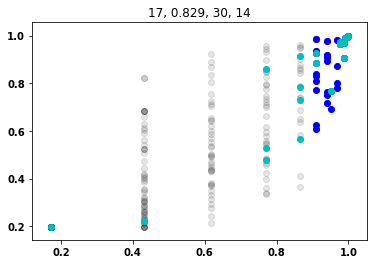

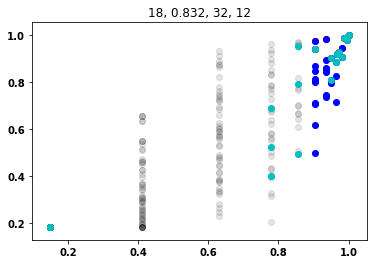

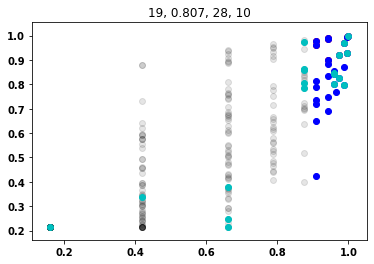

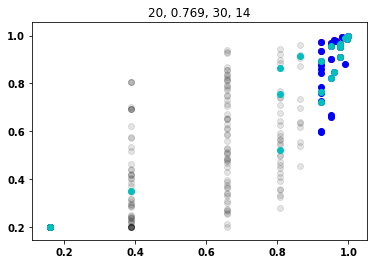

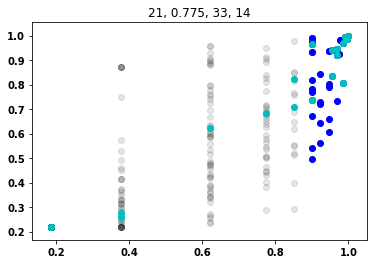

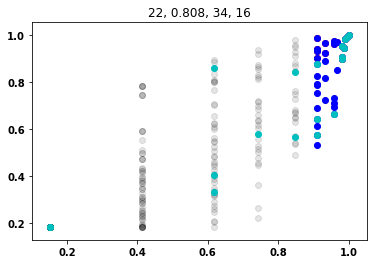

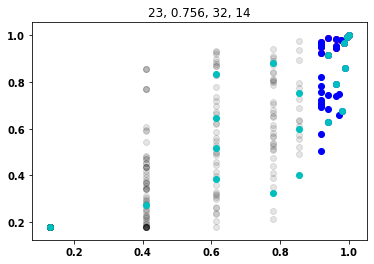

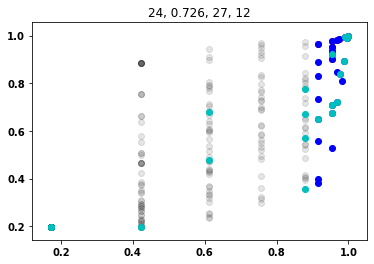

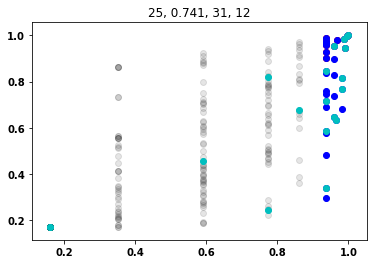

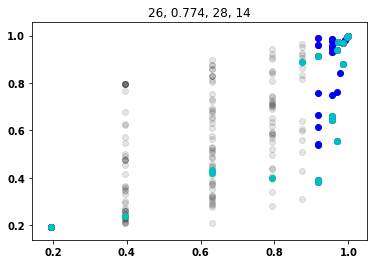

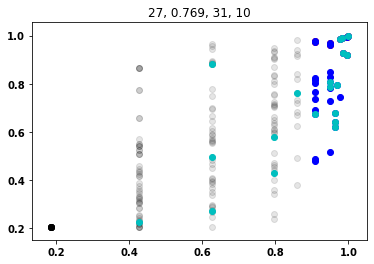

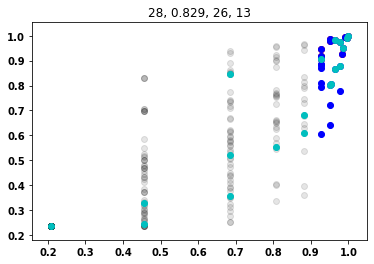

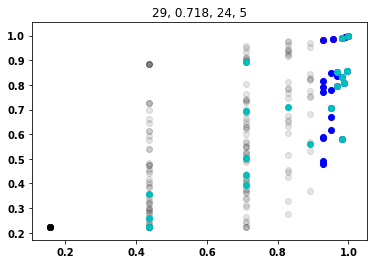

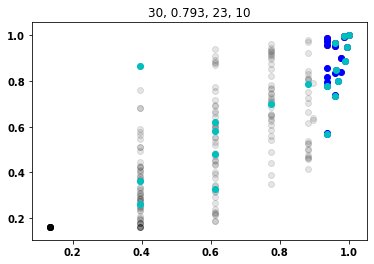

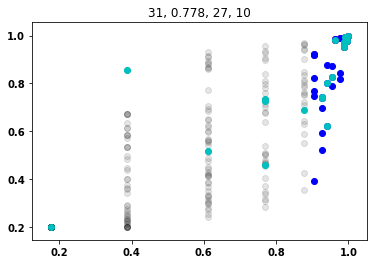

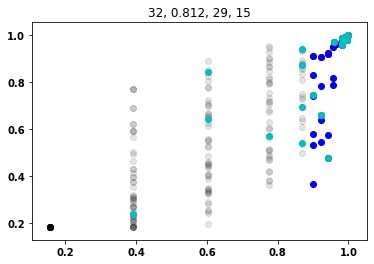

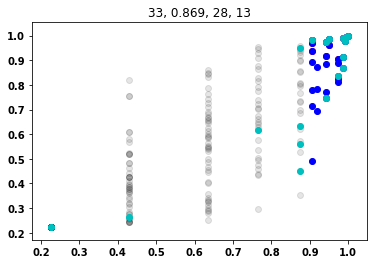

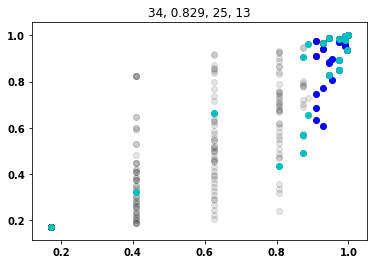

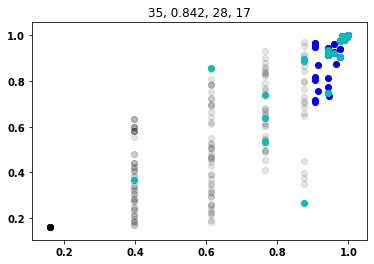

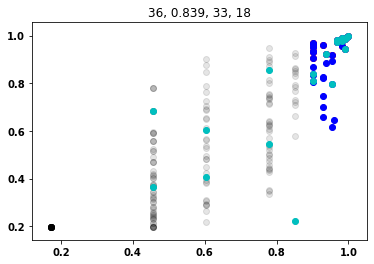

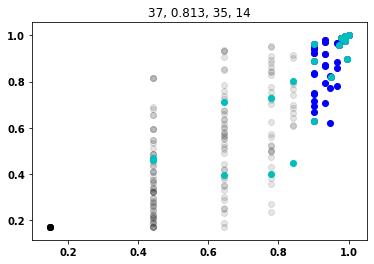

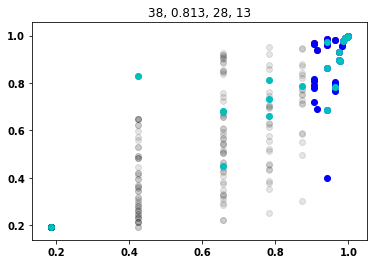

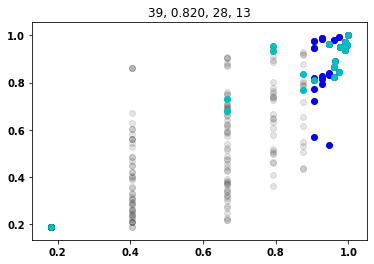

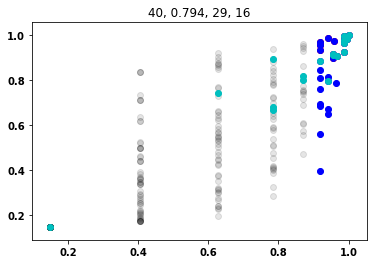

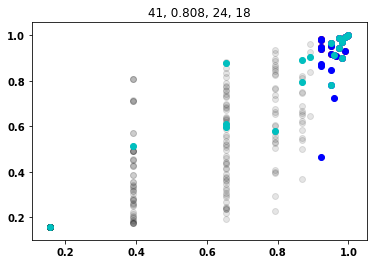

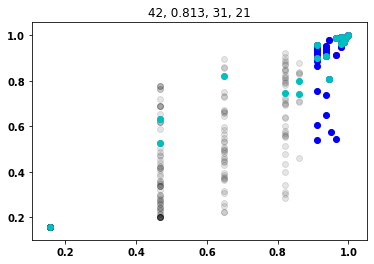

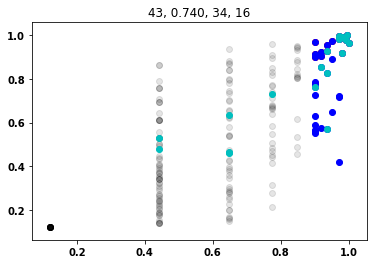

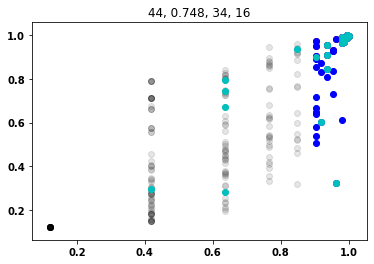

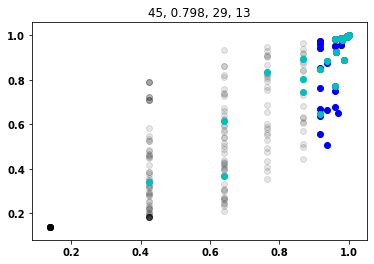

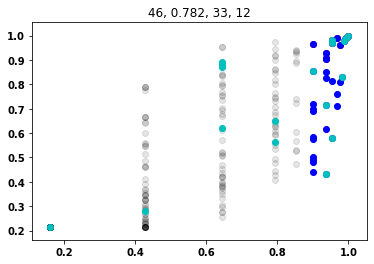

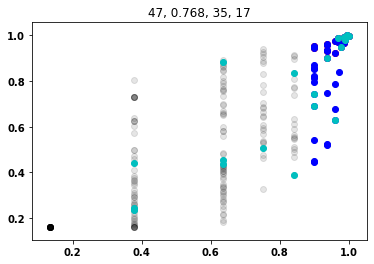

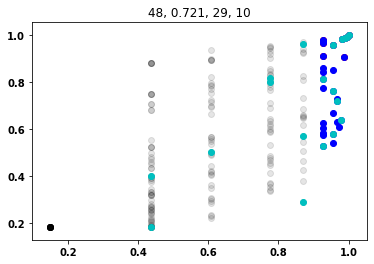

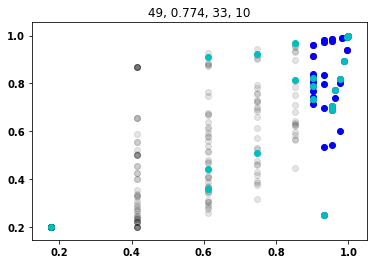

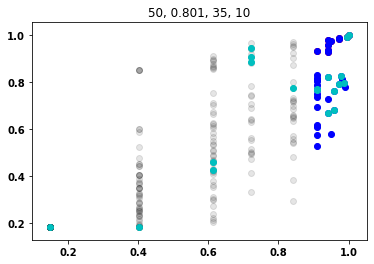

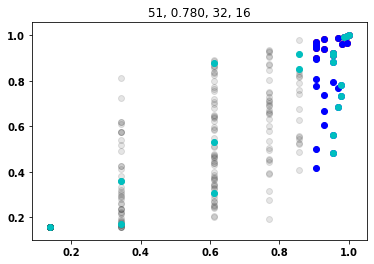

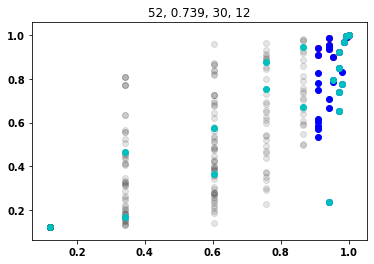

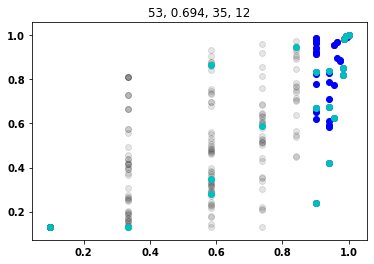

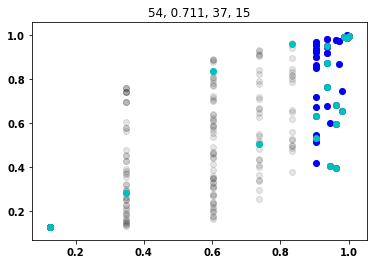

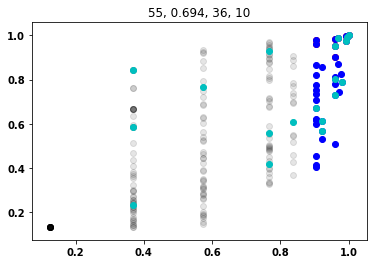

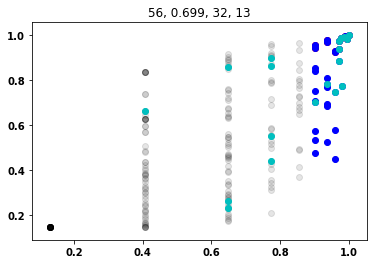

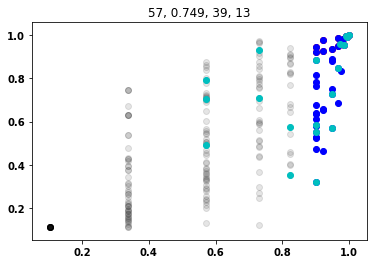

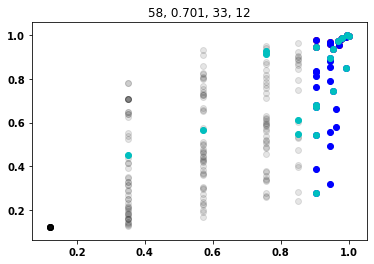

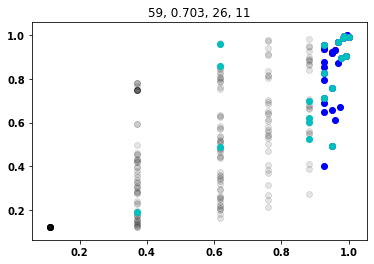

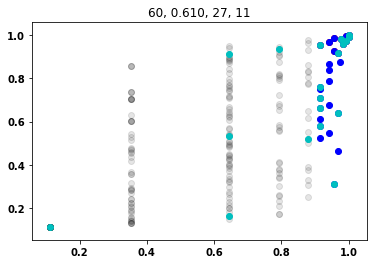

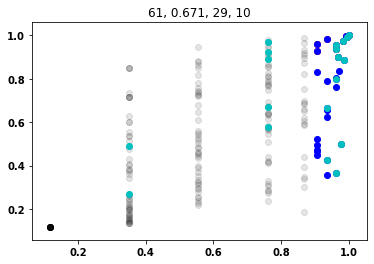

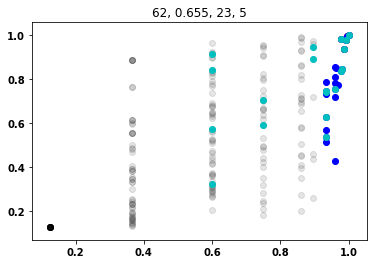

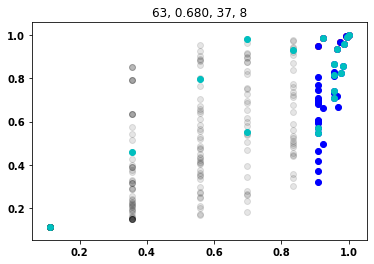

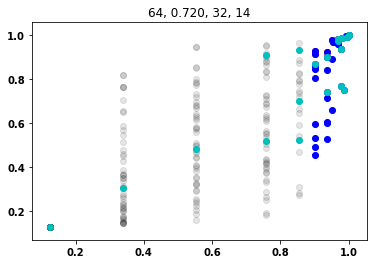

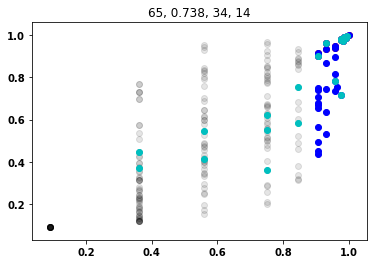

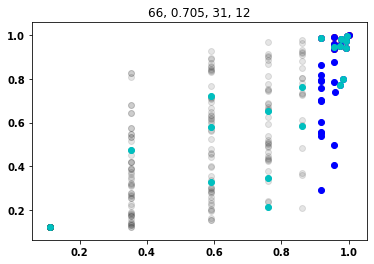

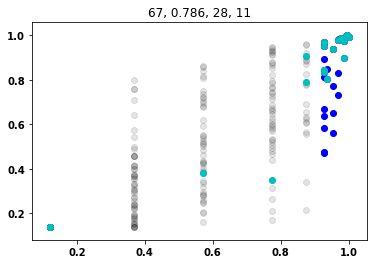

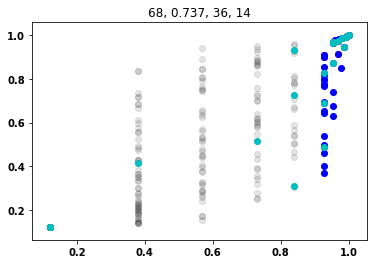

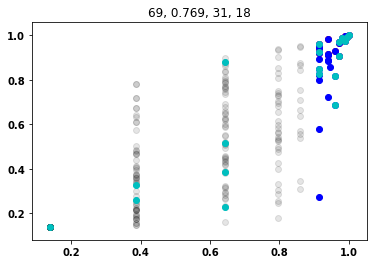

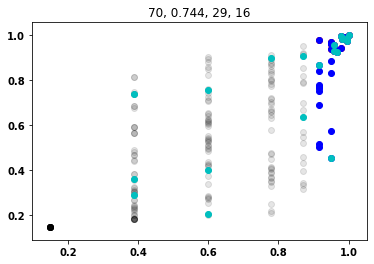

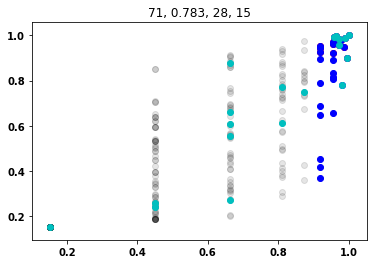

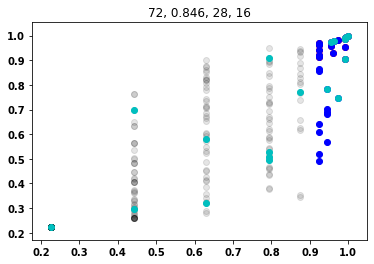

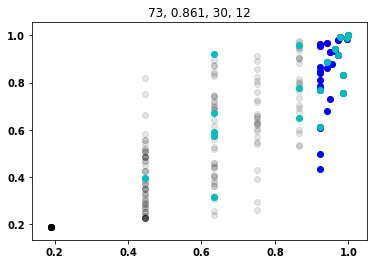

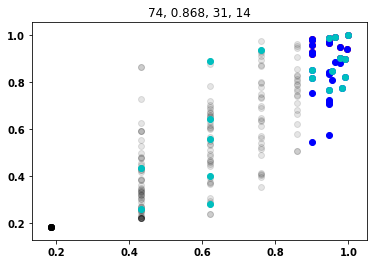

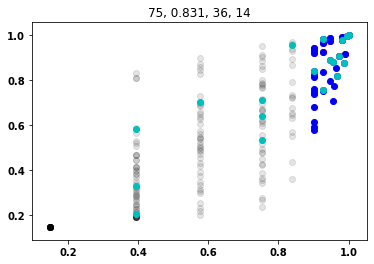

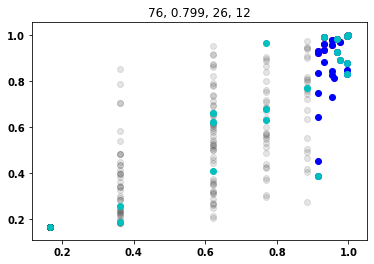

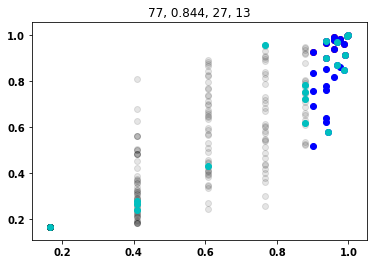

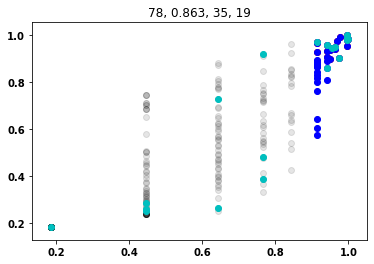

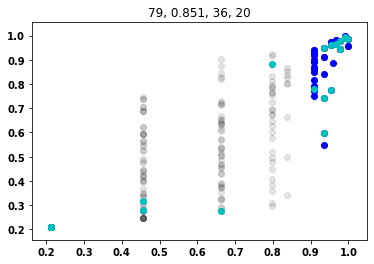

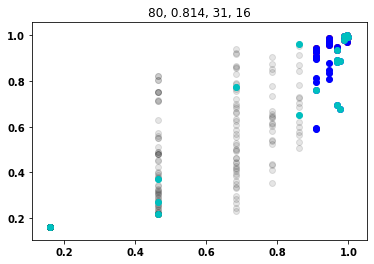

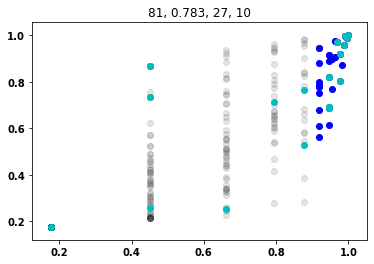

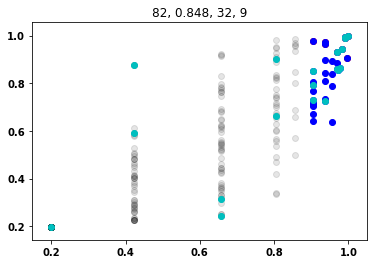

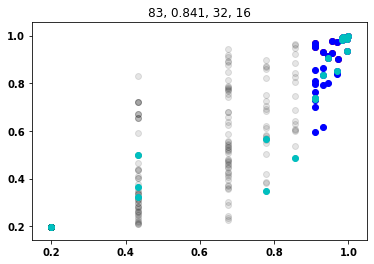

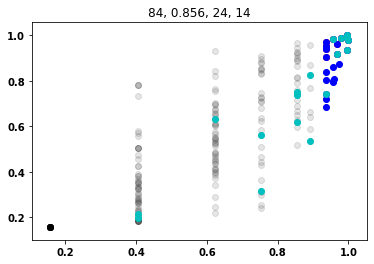

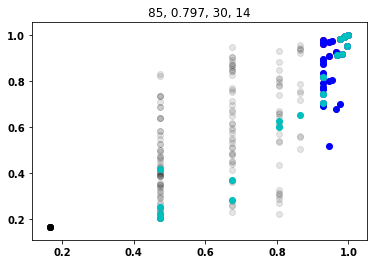

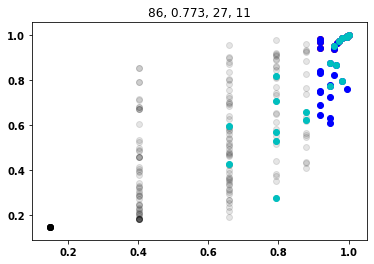

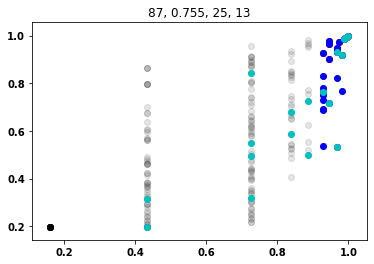

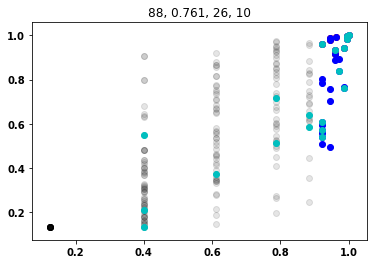

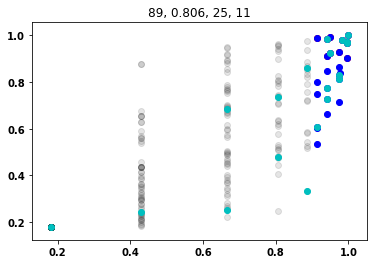

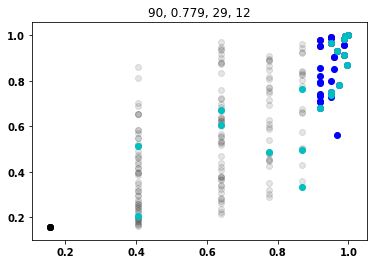

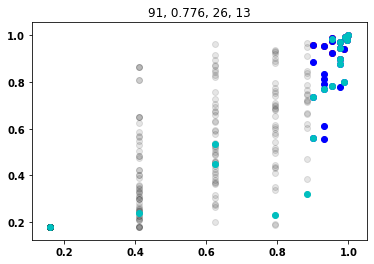

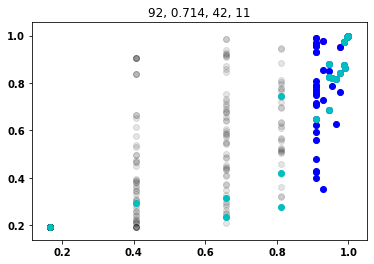

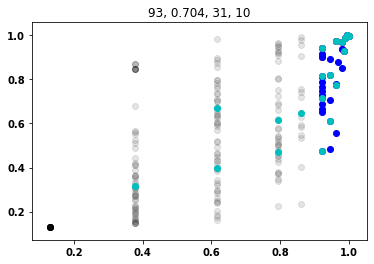

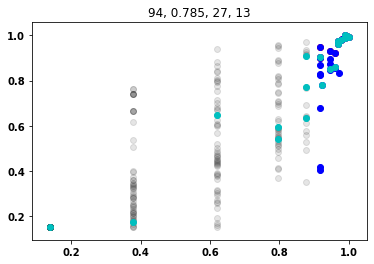

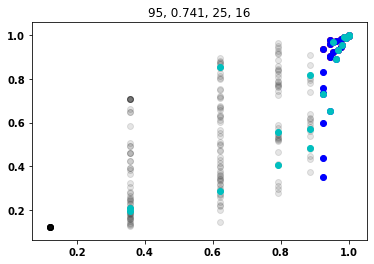

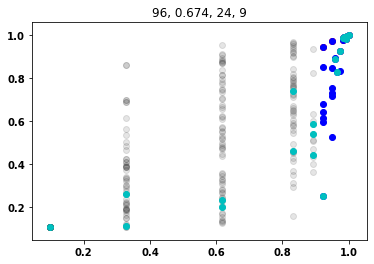

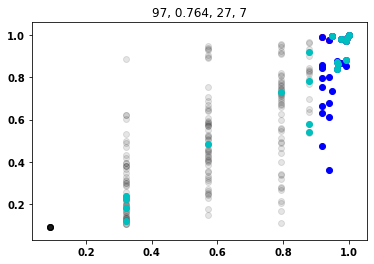

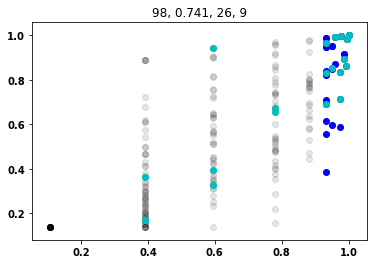

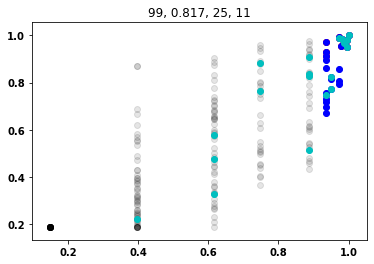

In [84]:
# cutoff = 0.90
# for i in range(0, 50, 1):
#     d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
#     superhubs = np.where( (d > cutoff) & (e > cutoff) )[0]
#     hubs      = np.where( (d > cutoff) )[0]
           
#     plt.figure()
#     plt.scatter(d,e, color='k', alpha=0.1)
#     plt.scatter(d[hubs], e[hubs], color='b')
#     plt.scatter(d[superhubs], e[superhubs], color='r')
#     plt.title('%i, %0.3f, %i, %i' % (i, dynamic_ev_deg_correlation[i], len(hubs), len(superhubs)))
#     plt.show()
    
    
    
    
cutoff = 0.90
for (idx,i) in enumerate(range(0, 100, 1)):
    d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]

    
    if idx == 0:
        init_superhubs = np.where( (d > cutoff) & (e > cutoff) )[0]
    superhubs = np.where( (d > cutoff) & (e > cutoff) )[0]
    hubs = np.where(d > cutoff)[0]
           
    plt.figure()
    plt.scatter(d,e, color='k', alpha=0.1)
    plt.scatter(d[superhubs], e[superhubs], color='r')
    plt.scatter(d[hubs], e[hubs], color='b')
    plt.scatter(d[init_superhubs], e[init_superhubs], color='c')
    plt.title('%i, %0.3f, %i, %i' % (i, dynamic_ev_deg_correlation[i], len(hubs), len(superhubs)))
    plt.show()

    

In [85]:
def extract_ensembles(idxs, component, temporal_cutoff, spatial_cutoff=0.90):
    from ensemble_utils import ensemble_detection
    
    raster = []
    for i in idxs:
        d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
        locs = None
        if component == 'shubs':
            locs = np.where( (d > spatial_cutoff) & (e > spatial_cutoff))[0]
        elif component == 'nhubs':
            locs = np.where(d > spatial_cutoff)[0]
        elif component == 'hubs':
            locs = np.where( (d > spatial_cutoff) & (e <= spatial_cutoff) )[0]
        raster_slice = np.zeros(len(d), dtype='uint8')
        raster_slice[locs] = 1
        raster.append(raster_slice)
        
    raster = np.asarray(raster, dtype='uint8')
    raster_mean = np.mean(raster, axis=0)
    mean_cutoff = np.percentile(raster_mean, temporal_cutoff*100.)
    valid_idxs = np.where(raster_mean > mean_cutoff)[0]
    raster = raster[:, valid_idxs]
    
    ensemble_kwargs = {'metric': 'cosine', 'k': 20, 'stopping_condition': 1e-3, 'resolution': 1.0}
    sam, umap_data, cluster_labels = ensemble_detection(raster.T, run_sam=True, **ensemble_kwargs)
    return sam, umap_data, cluster_labels, raster, valid_idxs

def sort_raster(raster, labels):
    labels = np.asarray(labels, dtype='uint32')
    sorted_raster = np.zeros_like(raster, dtype='uint8')
    label_set = np.sort(list(set(labels)))
    csz_lst = []
    for i in label_set:
        idxs = np.where(labels == i)[0]
        csize = len(idxs)
        csz_lst.append(csize)
    
    count = 0        
    for i in np.argsort(csz_lst):
        label = label_set[i]
        idxs = np.where(labels == label)[0]
        csz = len(idxs)
        sorted_raster[:,count:count+csz] = raster[:, idxs]
        count += csz
    return sorted_raster, np.sort(csz_lst)


def extract_modularity(xcorr, res):
    from ensemble_utils import leiden_clustering
    #from ensemble_utils import louvain_clustering
 
    #labels, modularity = networkx_clustering(np.clip(xcorr, 0., 1.))
    labels, modularity = leiden_clustering(np.clip(xcorr, 0., 1.) , res=res)
    return labels, modularity



In [113]:


temporal_cutoffs = np.arange(0.50, 0.95, 0.05, dtype='float32')
baseline_superhub_outputs, presz_superhub_outputs = {}, {}
baseline_naivehub_outputs, presz_naivehub_outputs = {}, {}
baseline_hub_outputs, presz_hub_outputs = {}, {}

for (i,tc) in enumerate(temporal_cutoffs):
    #s, e = 0, 360
    #baseline_superhub_sam, baseline_superhub_umap, baseline_superhub_clabels, baseline_superhub_raster, baseline_superhub_valid_idxs = extract_ensembles(range(s,e), 'shubs', tc)
    #baseline_naivehub_sam, baseline_naivehub_umap, baseline_naivehub_clabels, baseline_naivehub_raster, baseline_naivehub_valid_idxs = extract_ensembles(range(s,e), 'nhubs', tc)
    #baseline_hub_sam, baseline_hub_umap, baseline_hub_clabels, baseline_hub_raster, baseline_hub_valid_idxs = extract_ensembles(range(s,e), 'hubs', tc)


    s, e = 0, 600
    presz_superhub_sam, presz_superhub_umap, presz_superhub_clabels, presz_superhub_raster, presz_superhub_valid_idxs = extract_ensembles(range(s,e), 'shubs', tc)
    presz_naivehub_sam, presz_naivehub_umap, presz_naivehub_clabels, presz_naivehub_raster, presz_naivehub_valid_idxs = extract_ensembles(range(s,e), 'nhubs', tc)
    presz_hub_sam, presz_hub_umap, presz_hub_clabels, presz_hub_raster, presz_hub_valid_idxs = extract_ensembles(range(s,e), 'hubs', tc)


    #baseline_superhub_outputs[i] = {'sam': baseline_superhub_sam, 'umap': baseline_superhub_umap, 'labels': baseline_superhub_clabels, 'raster': baseline_superhub_raster, 'sorted raster': None, 'valid idxs': baseline_superhub_valid_idxs}
    #baseline_naivehub_outputs[i] = {'sam': baseline_naivehub_sam, 'umap': baseline_naivehub_umap, 'labels': baseline_naivehub_clabels, 'raster': baseline_naivehub_raster, 'sorted raster': None, 'valid idxs': baseline_naivehub_valid_idxs}
    #baseline_hub_outputs[i] = {'sam': baseline_hub_sam, 'umap': baseline_hub_umap, 'labels': baseline_hub_clabels, 'raster': baseline_hub_raster, 'sorted raster': None, 'valid idxs': baseline_hub_valid_idxs}

    
    presz_superhub_outputs[i] = {'sam': presz_superhub_sam, 'umap': presz_superhub_umap, 'labels': presz_superhub_clabels, 'raster': presz_superhub_raster, 'sorted raster': None, 'valid idxs': presz_superhub_valid_idxs}
    presz_naivehub_outputs[i] = {'sam': presz_naivehub_sam, 'umap': presz_naivehub_umap, 'labels': presz_naivehub_clabels, 'raster': presz_naivehub_raster, 'sorted raster': None, 'valid idxs': presz_naivehub_valid_idxs}
    presz_hub_outputs[i] = {'sam': presz_hub_sam, 'umap': presz_hub_umap, 'labels': presz_hub_clabels, 'raster': presz_hub_raster, 'sorted raster': None, 'valid idxs': presz_hub_valid_idxs}
    
    print(i, tc, len(temporal_cutoffs))

Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


0 0.5 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


1 0.55 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


2 0.6 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


3 0.65000004 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


4 0.70000005 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


5 0.75000006 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


6 0.8000001 9


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


7 0.8500001 9


Transforming to str index.
Transforming to str index.


8 0.9000001 9


In [114]:
# sort and get modularities of 
def update(X):
    res = 1.0
    sorted_raster, csz_lst = sort_raster(X['raster'], X['labels'])
    X['sorted raster'] = sorted_raster
    X['csz_lst'] = csz_lst
    slabels, smod = extract_modularity(np.corrcoef(sorted_raster.T), res)
    tlabels, tmod = extract_modularity(np.corrcoef(sorted_raster), res)
    X['slabels'] = slabels
    X['tlabels'] = tlabels
    X['smod'] = smod
    X['tmod'] = tmod


sorted_keys = np.sort(list(presz_superhub_outputs.keys()))
for key in sorted_keys:
    print('...start %d' % key)
    # superhubs
    #update(baseline_superhub_outputs[key])
    update(presz_superhub_outputs[key])
  
    
    # hubs
    #update(baseline_hub_outputs[key])
    update(presz_hub_outputs[key])
    
    # naive hubs
    #update(baseline_naivehub_outputs[key])
    update(presz_naivehub_outputs[key])
    



...start 0
...start 1
...start 2
...start 3
...start 4
...start 5
...start 6
...start 7
...start 8


In [101]:
# plot modularities
def plot_umap_clusters(umap, labels):
    labels = np.asarray(labels, dtype='uint32')
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].scatter(*umap.T, color='k')
    for i in range(np.min(labels), np.max(labels) + 1):
        idxs = np.where(labels == i)[0]
        ax[1].scatter(*umap[idxs,:].T)
    plt.show()
    
def plot_modularities(X, xvals, labels):
    xvals = xvals[:-1]
    colors = ['k', 'r', 'b']
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    for (xp, x) in enumerate(X):
        smod, tmod = [], []
        sorted_keys = np.sort(list(x.keys()))
        for key in sorted_keys[:-1]:
            smod.append(x[key]['smod'])
            tmod.append(x[key]['tmod'])
            
        ax[0].plot(xvals, smod, color=colors[xp], label=labels[xp])
        ax[1].plot(xvals, tmod, color=colors[xp], label=labels[xp])

        #ax[0].legend()
        #ax[1].legend()
        
    plt.show()
    
def plot_raster_info(mean_trace, idxs, data_dict, title):
    
    sorted_raster = data_dict['sorted raster']
    csz_lst       = data_dict['csz_lst']
    T = sorted_raster.shape[0]
    
    spatial_corr = np.corrcoef(sorted_raster.T)
    spatial_modularity   = data_dict['smod']  
    
    temporal_corr = np.corrcoef(sorted_raster)
    temporal_modularity   = data_dict['tmod']   
    
    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].set_title(title)
    ax[0].imshow(sorted_raster.T, cmap='gray', vmin=0., vmax=1., aspect='auto')
    count = 0
    for sz in csz_lst:
        ax[0].plot(range(T), np.ones(T) * count, color='c')
        count += sz
    #ax2 = ax[0].twinx()
    #ax2.plot(np.range(-120, idxs[-1]))
    ax[1].imshow(spatial_corr, cmap='gray_r', vmin=0., vmax=1.)
    ax[1].set_title('spatial modularity: %0.3f' % spatial_modularity)
    ax[2].imshow(temporal_corr, cmap='gray_r', vmin=0., vmax=1.)
    ax[2].set_title('temporal modularity: %0.3f' % temporal_modularity)
    plt.show()



    

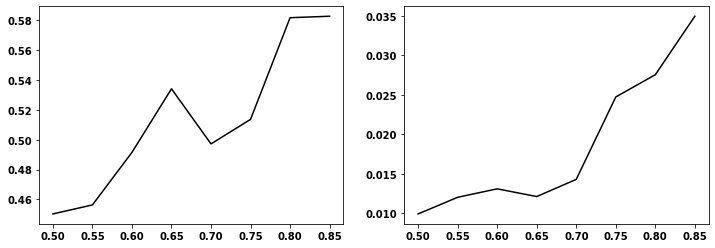

In [115]:
#plot_modularities([baseline_superhub_outputs, presz_superhub_outputs], temporal_cutoffs, ['baseline shub', 'presz shub'])
plot_modularities([presz_superhub_outputs], temporal_cutoffs, ['presz shub'])


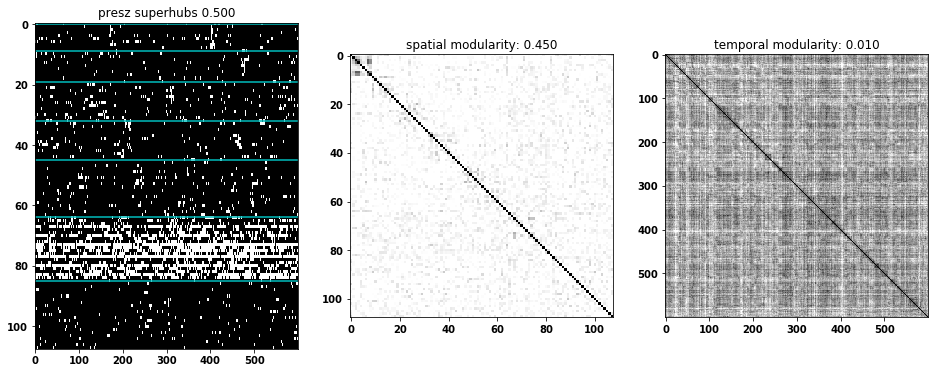

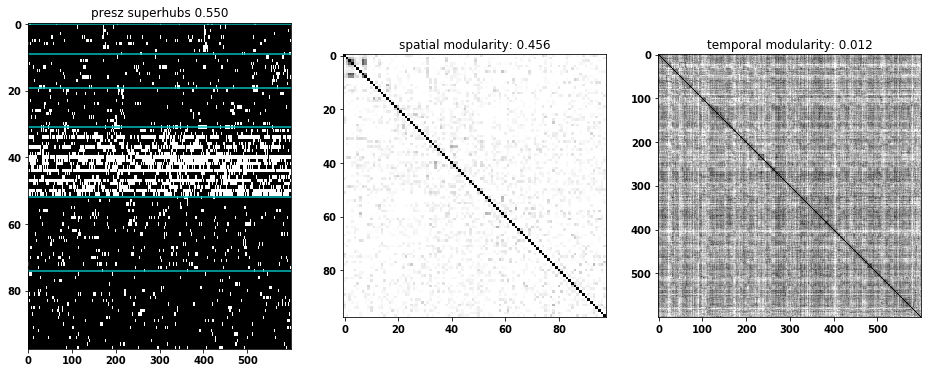

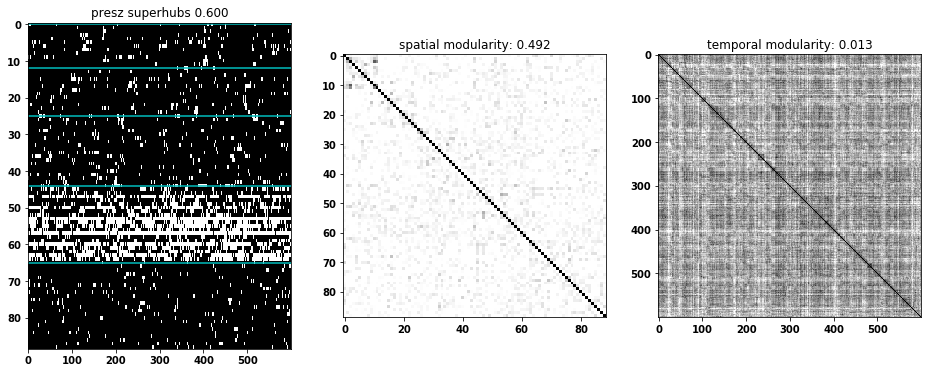

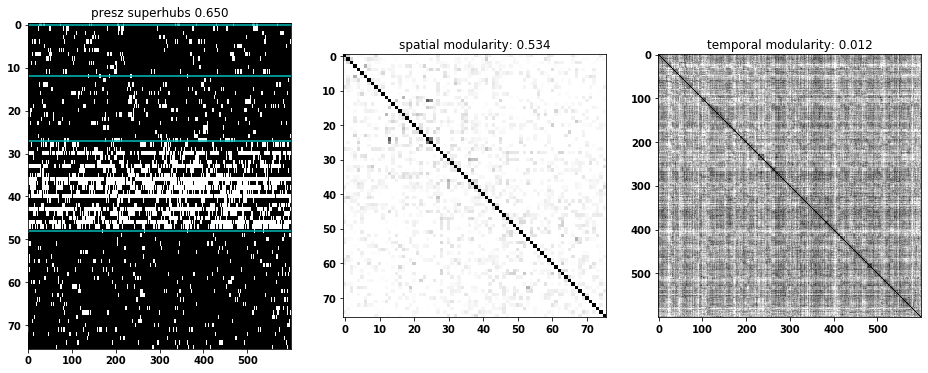

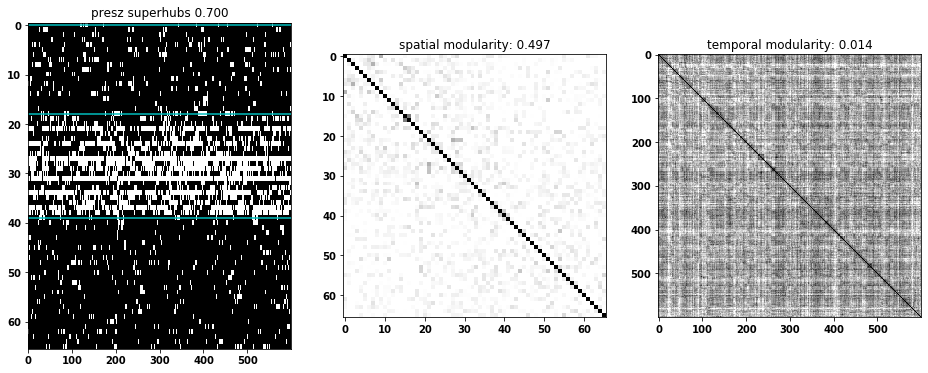

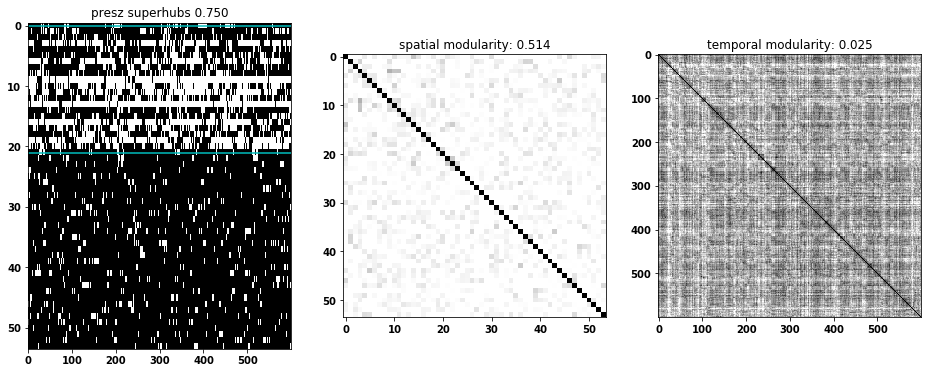

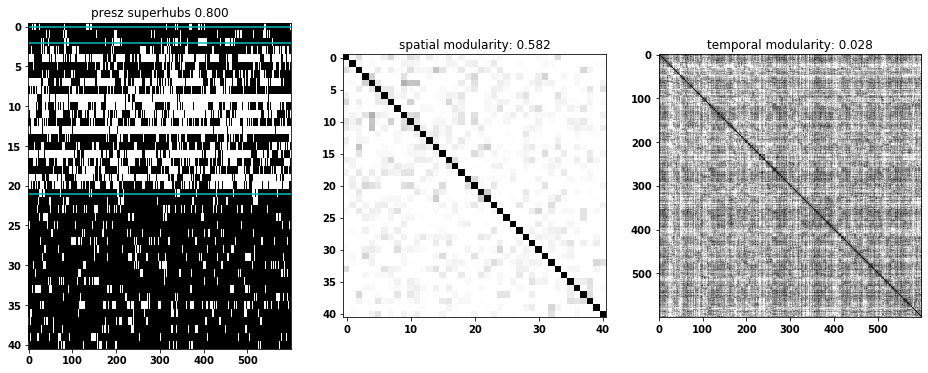

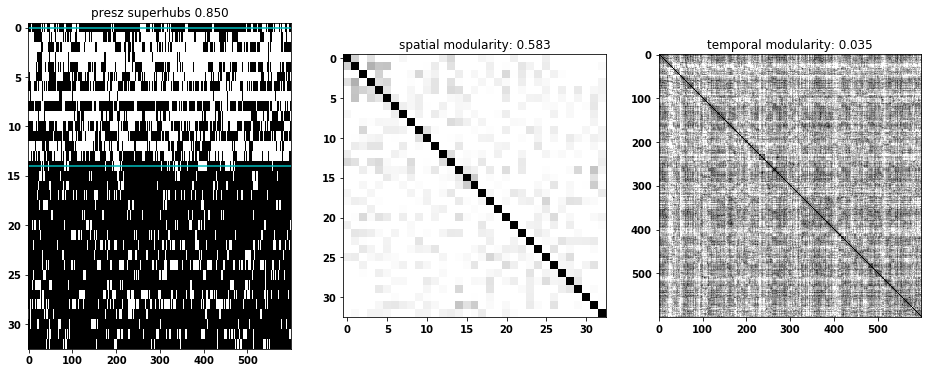

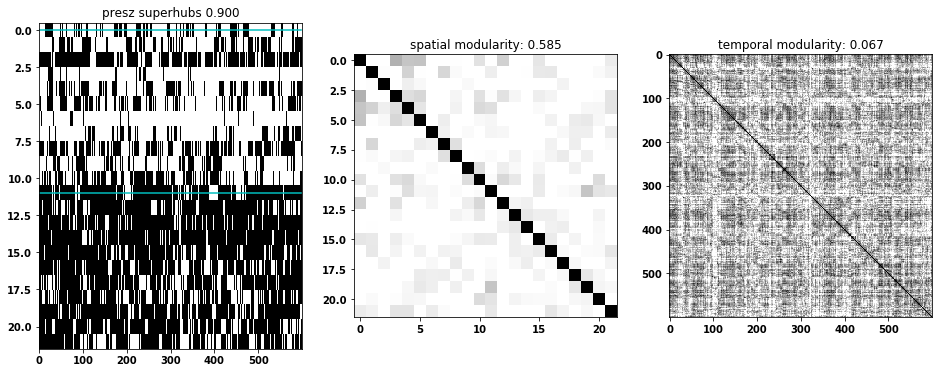

In [116]:
for key in sorted_keys:
    plot_raster_info(np.mean(traces,axis=0), range(0, 360), presz_superhub_outputs[key], 'presz superhubs %0.3f' % temporal_cutoffs[key])